In [ ]:
import os
import json
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

ZIP_PATH_DRIVE = "/content/drive/MyDrive/Colab Notebooks/ad_and_mo/GTSRB_prepared.zip"
DATA_ROOT = "/content/GTSRB_prepared"

import shutil, zipfile, os

if os.path.exists(DATA_ROOT):
    shutil.rmtree(DATA_ROOT)

os.makedirs(DATA_ROOT, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH_DRIVE, 'r') as zip_ref:
    zip_ref.extractall(DATA_ROOT)

!ls -R /content/GTSRB_prepared

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = DATA_ROOT
TRAIN_PATH = os.path.join(DATA_PATH, "Train")
PROCESSED_TEST_PATH = os.path.join(DATA_PATH, "ProcessedTest")
META_PATH = os.path.join(DATA_PATH, "split_meta")

RESULTS_DIR = "/content/resnet18_results"
os.makedirs(RESULTS_DIR, exist_ok=True)


In [ ]:
def load_split_metadata(meta_path):
    with open(os.path.join(meta_path, 'train_indices.json'), 'r') as f:
        train_indices = json.load(f)
    with open(os.path.join(meta_path, 'val_indices.json'), 'r') as f:
        val_indices = json.load(f)
    with open(os.path.join(meta_path, 'test_indices.json'), 'r') as f:
        test_indices = json.load(f)
    with open(os.path.join(meta_path, 'class_to_idx.json'), 'r') as f:
        class_to_idx = json.load(f)
    return train_indices, val_indices, test_indices, class_to_idx

train_indices, val_indices, test_indices, class_to_idx = load_split_metadata(META_PATH)
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Internal Test: {len(test_indices)}")
print(f"Количество классов: {len(class_to_idx)}")

idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

IMG_SIZE = 224

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

dataset_train_full = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
dataset_val_full   = datasets.ImageFolder(root=TRAIN_PATH, transform=val_test_transform)

train_dataset = Subset(dataset_train_full, train_indices)
val_dataset   = Subset(dataset_val_full,   val_indices)

print(f"Размер train_dataset: {len(train_dataset)}")
print(f"Размер val_dataset:   {len(val_dataset)}")

processed_test_dataset = datasets.ImageFolder(
    root=PROCESSED_TEST_PATH,
    transform=val_test_transform
)
print(f"Размер processed_test_dataset: {len(processed_test_dataset)}")
print(f"Число классов в ProcessedTest: {len(processed_test_dataset.classes)}")


Train: 27446, Val: 5881, Internal Test: 5882
Количество классов: 43
Размер train_dataset: 27446
Размер val_dataset:   5881
Размер processed_test_dataset: 12630
Число классов в ProcessedTest: 43


In [ ]:
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

final_test_loader = DataLoader(
    processed_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double().item() / len(loader.dataset)
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val/Test", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double().item() / len(loader.dataset)
    return epoch_loss, epoch_acc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]



Epoch 1/20


Train  Loss: 0.1521 | Acc: 0.9479
Val    Loss: 0.1407 | Acc: 0.9568

Epoch 2/20


Train  Loss: 0.0885 | Acc: 0.9702
Val    Loss: 0.0850 | Acc: 0.9726

Epoch 3/20


Train  Loss: 0.0755 | Acc: 0.9769
Val    Loss: 0.0672 | Acc: 0.9787

Epoch 4/20


Train  Loss: 0.0649 | Acc: 0.9792
Val    Loss: 0.1523 | Acc: 0.9451

Epoch 5/20


Train  Loss: 0.0632 | Acc: 0.9799
Val    Loss: 0.0560 | Acc: 0.9810

Epoch 6/20


Train  Loss: 0.0191 | Acc: 0.9946
Val    Loss: 0.0079 | Acc: 0.9981

Epoch 7/20


Train  Loss: 0.0090 | Acc: 0.9974
Val    Loss: 0.0047 | Acc: 0.9986

Epoch 8/20


Train  Loss: 0.0070 | Acc: 0.9978
Val    Loss: 0.0037 | Acc: 0.9990

Epoch 9/20


Train  Loss: 0.0049 | Acc: 0.9986
Val    Loss: 0.0033 | Acc: 0.9988

Epoch 10/20


Train  Loss: 0.0045 | Acc: 0.9987
Val    Loss: 0.0060 | Acc: 0.9981

Epoch 11/20


Train  Loss: 0.0038 | Acc: 0.9990
Val    Loss: 0.0036 | Acc: 0.9986

Epoch 12/20


Train  Loss: 0.0027 | Acc: 0.9994
Val    Loss: 0.0033 | Acc: 0.9986

Epoch 13/20


Train  Loss: 0.0025 | Acc: 0.9994
Val    Loss: 0.0028 | Acc: 0.9990

Epoch 14/20


Train  Loss: 0.0019 | Acc: 0.9996
Val    Loss: 0.0022 | Acc: 0.9993

Epoch 15/20


Train  Loss: 0.0019 | Acc: 0.9997
Val    Loss: 0.0025 | Acc: 0.9991

Epoch 16/20


Train  Loss: 0.0021 | Acc: 0.9996
Val    Loss: 0.0025 | Acc: 0.9993

Epoch 17/20


Train  Loss: 0.0015 | Acc: 0.9998
Val    Loss: 0.0025 | Acc: 0.9993

Epoch 18/20


Train  Loss: 0.0017 | Acc: 0.9997
Val    Loss: 0.0026 | Acc: 0.9990

Epoch 19/20


Train  Loss: 0.0016 | Acc: 0.9999
Val    Loss: 0.0025 | Acc: 0.9991

Epoch 20/20


Train  Loss: 0.0018 | Acc: 0.9997
Val    Loss: 0.0025 | Acc: 0.9993

Лучшее val accuracy: 0.9993
Модель сохранена в: /content/resnet18_results/model_resnet18.pth


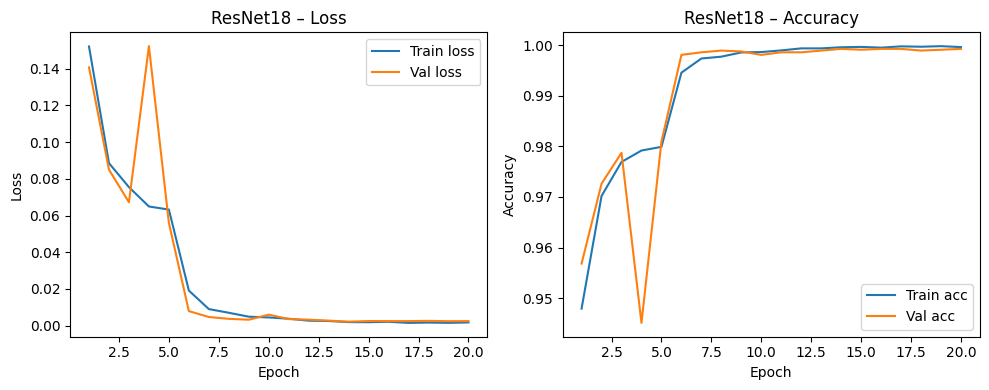

Графики обучения сохранены в: /content/resnet18_results/resnet18_training_curves.png


Final test: 100%|██████████| 198/198 [00:24<00:00,  7.94it/s]



Final test accuracy (ProcessedTest): 0.0621

Classification report (ProcessedTest):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     0.9972    1.0000    0.9986       720
          10     0.0000    0.0000    0.0000       750
          11     0.0000    0.0000    0.0000       450
          12     0.0000    0.0000    0.0000       660
          13     0.0000    0.0000    0.0000       630
          14     0.0000    0.0000    0.0000       150
          15     0.0000    0.0000    0.0000       450
          16     0.0000    0.0000    0.0000       450
          17     0.0000    0.0000    0.0000       480
          18     0.0000    0.0000    0.0000       660
          19     0.0000    0.0000    0.0000       420
           2     0.0000    0.0000    0.0000       690
          20     0.0000    0.0000    0.0000       720
          21     0.0000    0.0000    0.0000       270
          22     0.0000    0.0000    0.0000       

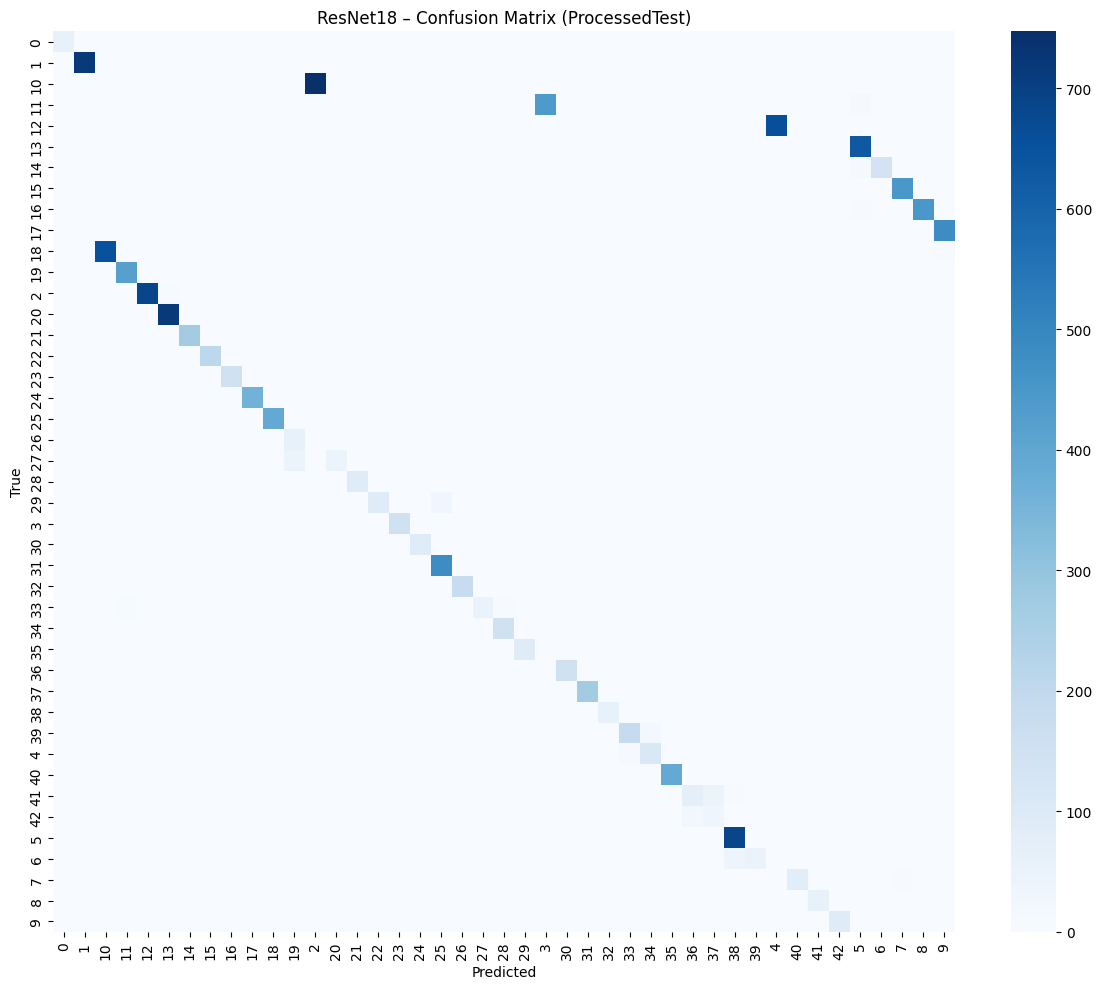

Confusion matrix сохранена в: /content/resnet18_results/resnet18_confusion_matrix.png


In [ ]:
best_val_acc = 0.0
best_model_state = None

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(resnet18, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(resnet18, val_loader, criterion, device)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Train  Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val    Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = resnet18.state_dict().copy()

print(f"\nЛучшее val accuracy: {best_val_acc:.4f}")

if best_model_state is not None:
    resnet18.load_state_dict(best_model_state)

model_path = os.path.join(RESULTS_DIR, "model_resnet18.pth")
torch.save(resnet18.state_dict(), model_path)
print(f"Модель сохранена в: {model_path}")

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ResNet18 – Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet18 – Accuracy")

curves_path = os.path.join(RESULTS_DIR, "resnet18_training_curves.png")
plt.tight_layout()
plt.savefig(curves_path, dpi=300)
plt.show()
print(f"Графики обучения сохранены в: {curves_path}")

resnet18.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(final_test_loader, desc="Final test"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_acc = (all_labels == all_preds).mean()
print(f"\nFinal test accuracy (ProcessedTest): {test_acc:.4f}")

class_labels_ordered = [idx_to_class[i] for i in range(num_classes)]

report = classification_report(
    all_labels,
    all_preds,
    target_names=class_labels_ordered,
    digits=4
)
print("\nClassification report (ProcessedTest):")
print(report)

report_path = os.path.join(RESULTS_DIR, "resnet18_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Final test accuracy: {test_acc:.4f}\n\n")
    f.write(report)
print(f"Отчёт по метрикам сохранён в: {report_path}")
и
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels_ordered,
    yticklabels=class_labels_ordered
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet18 – Confusion Matrix (ProcessedTest)")
cm_path = os.path.join(RESULTS_DIR, "resnet18_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"Confusion matrix сохранена в: {cm_path}")
